In [1]:
import argparse
import os
import numpy as np
import math
import glob

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Machine_Learning/GAN/div2k/data/') #/
!pwd
%ls

/content/drive/MyDrive/Machine_Learning/GAN/div2k/data
DiffAugment_pytorch.py  DIV2K_train_HR/  images/  __pycache__/  saved_models/


In [4]:
import sys
sys.argv=['']
del sys

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=0, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00005, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=1, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=1000, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=128, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=30, help="interval betwen image samples")
opt = parser.parse_args()
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=3, img_size=128, latent_dim=1000, lr=5e-05, n_cpu=1, n_epochs=0, sample_interval=30)


In [5]:
# Normalization parameters for pre-trained PyTorch models
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, lr_shape):
        lr_height, lr_width = lr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((lr_height, lr_height), Image.BICUBIC),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        return {"lr": img_lr}

    def __len__(self):
        return len(self.files)

# Configure data loader
dataset_path = "DIV2K_train_HR"
lr_shape=(opt.img_size, opt.img_size)
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.2)
dataloader = DataLoader(ImageDataset(train_paths, lr_shape=lr_shape), batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [6]:
class Generator(nn.Module):
    def __init__(self, out_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(opt.latent_dim, 64, 4, 1, 0),#, bias=False
            #nn.BatchNorm2d(64*16),
            nn.ReLU(True),
            # state size. 64*16 x 4 x 4
            nn.ConvTranspose2d(64, 64, 4, 2, 1),
            #nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            # state size. 64*8 x 8 x 8
            nn.ConvTranspose2d(64, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64*4),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64*4 x 16 x 16
            nn.ConvTranspose2d(64, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64*2),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64*2 x 32 x 32
            nn.ConvTranspose2d(64, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            #self attention
            #Self_Attn(64),
            # state size. 64 x 64 x 64            
            nn.ConvTranspose2d(64, opt.channels, 4, 2, 1, ),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, out_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (out_channels) x 128 x 128
            nn.Conv2d(opt.channels, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 64 x 64
            nn.Conv2d(64, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64),#*2
            #nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 32 x 32
            nn.Conv2d(64, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64),#*4
            #nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 16 x 15
            nn.Conv2d(64, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64),#*8
            #nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),            
            # state size. 64*16 x 8 x 8
            nn.Conv2d(64, 64, 4, 2, 1, ),
            #nn.BatchNorm2d(64),#*16
            #nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            #self attention
            #Self_Attn(64),
            # state size. 64*16 x 4 x 4
            nn.Conv2d(64, 1, 4, 1, 0, ),
            #nn.Dropout(0.2),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        crit_pred = self.main(input)
        return crit_pred.view(len(crit_pred), -1)

In [8]:
# Initialize generator and discriminator
from torchsummary import summary
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = torch.nn.BCELoss() #BCEWithLogitsLoss()#

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

summary(generator, (opt.latent_dim,1,1))
summary(discriminator, (opt.channels,128,128))

# Load pretrained models
load_pretrained_models = True
generator_path = "saved_models/generator.pth"
discriminator_path = "saved_models/discriminator.pth"
if load_pretrained_models:
    generator.load_state_dict(torch.load(generator_path,map_location=DEVICE))#map_location=torch.device('cpu')
    discriminator.load_state_dict(torch.load(discriminator_path,map_location=DEVICE))#CPU only

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 4, 4]       1,024,064
              ReLU-2             [-1, 64, 4, 4]               0
   ConvTranspose2d-3             [-1, 64, 8, 8]          65,600
              ReLU-4             [-1, 64, 8, 8]               0
   ConvTranspose2d-5           [-1, 64, 16, 16]          65,600
              ReLU-6           [-1, 64, 16, 16]               0
   ConvTranspose2d-7           [-1, 64, 32, 32]          65,600
              ReLU-8           [-1, 64, 32, 32]               0
   ConvTranspose2d-9           [-1, 64, 64, 64]          65,600
             ReLU-10           [-1, 64, 64, 64]               0
  ConvTranspose2d-11          [-1, 3, 128, 128]           3,075
             Tanh-12          [-1, 3, 128, 128]               0
Total params: 1,289,539
Trainable params: 1,289,539
Non-trainable params: 0
---------------------------

In [9]:
# ----------
#  Training
# ----------

#https://github.com/mit-han-lab/data-efficient-gans-dynamic
from DiffAugment_pytorch import DiffAugment
policy = 'color,translation,cutout'#

for epoch in range(opt.n_epochs):

    #tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, imgs in enumerate(dataloader):

        # Configure model input
        real_imgs = Variable(imgs["lr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_imgs.size(0), 1))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_imgs.size(0), 1))), requires_grad=False)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Sample noise as generator input
        z = Variable(torch.randn(opt.batch_size,opt.latent_dim, 1, 1, device=DEVICE))#
        # Generate a batch of images
        gen_imgs = generator(z)

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(DiffAugment(real_imgs, policy=policy)), valid)
        fake_loss = adversarial_loss(discriminator(DiffAugment(gen_imgs, policy=policy).detach()), fake)
        d_loss = (real_loss + fake_loss) #/ 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        z_2 = Variable(torch.randn(opt.batch_size,opt.latent_dim, 1, 1, device=DEVICE))#
        # Generate a batch of images
        gen_imgs_2 = generator(z_2)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(DiffAugment(gen_imgs_2, policy=policy)), valid)

        g_loss.backward()
        optimizer_G.step()


        if epoch % 10 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        #batches_done = epoch * len(dataloader) + i
        if epoch % opt.sample_interval == 0:
            save_image(gen_imgs.data[:9], "images/%d.png" % epoch, nrow=3, normalize=True)

        # Save model checkpoints
        if (epoch+1)%1000 == 0:
            torch.save(generator.state_dict(), "saved_models/generator.pth")
            torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

#torch.save(generator.state_dict(), "saved_models/generator.pth")
#torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


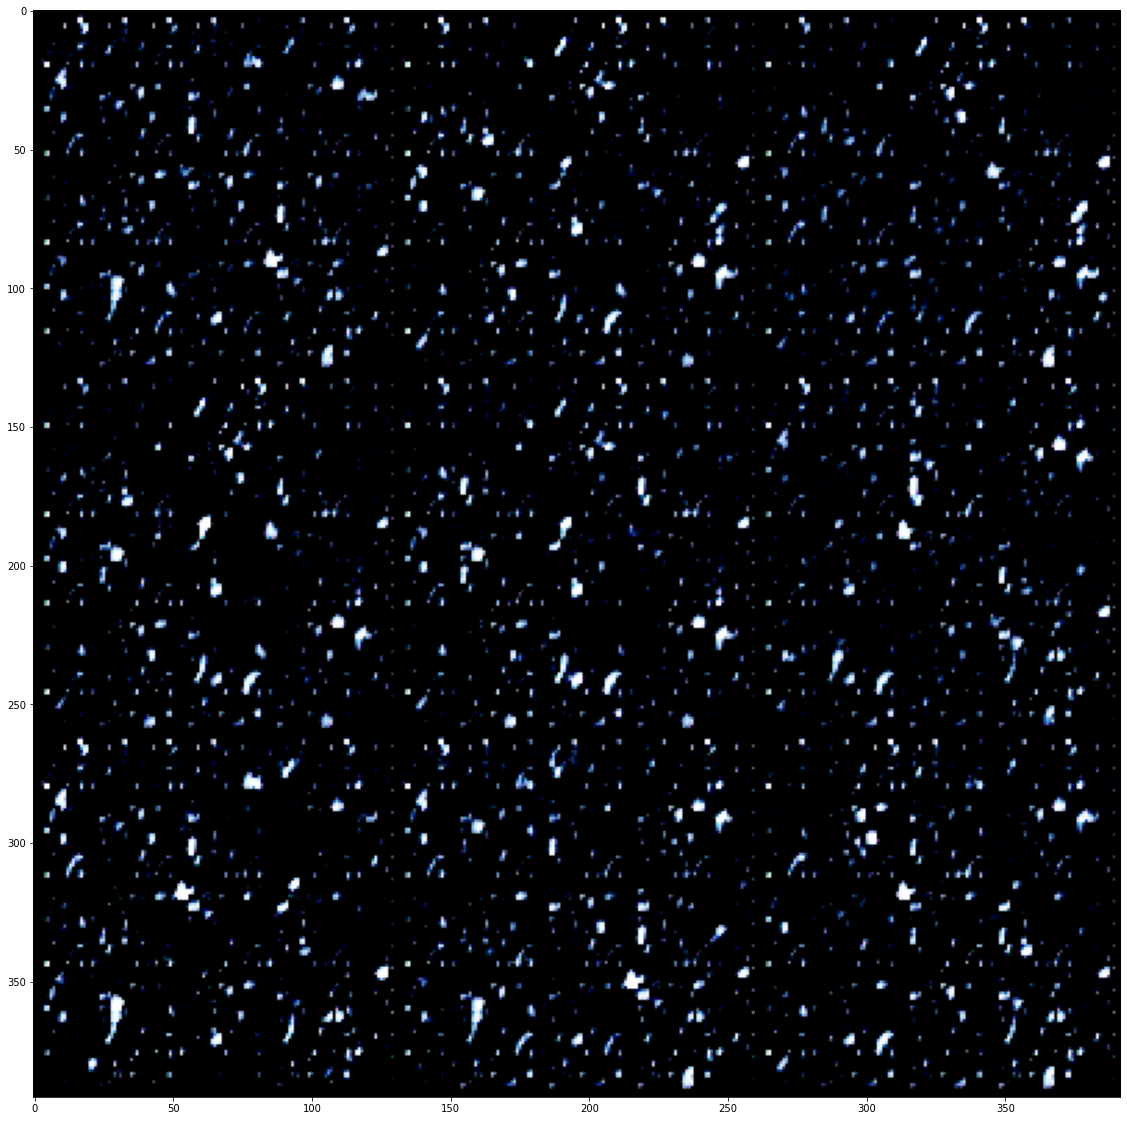

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

z = Variable(torch.randn(opt.batch_size,opt.latent_dim, 1, 1, device=DEVICE))
gen_imgs = generator(z)

grid_img = make_grid(gen_imgs.data.cpu()[:9], nrow=3)
plt.figure(figsize = (20,20))
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')

In [11]:
#https://towardsdatascience.com/building-your-own-self-attention-gans-e8c9b9fe8e51
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super().__init__()
        
        # Construct the conv layers
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)#//2
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        
        # Initialize gamma as 0
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B * C * W * H)
            returns :
                out : self attention value + input feature 
                attention: B * N * N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        
        proj_query  = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0,2,1) # B * N * C
        proj_key =  self.key_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        energy =  torch.bmm(proj_query, proj_key) # batch matrix-matrix product
        
        attention = self.softmax(energy) # B * N * N
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        out = torch.bmm(proj_value, attention.permute(0,2,1)) # batch matrix-matrix product
        out = out.view(m_batchsize,C,width,height) # B * C * W * H
        
        # Add attention weights onto input
        out = self.gamma*out + x
        return out#, attention